Bayesian Neural Network model traning and prediction data generation.

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import pickle

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tf.keras.backend.set_floatx("float32")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from scipy.stats import norm

Load the training databases, generated in player_match_database_creation

In [4]:
db1 = pd.read_excel('mid_outputs/database_entries.xlsx', index_col = 0)   
db2 = pd.read_excel('mid_outputs/season2021/database_entries.xlsx', index_col = 0)   
db3 = pd.read_excel('mid_outputs/season2122/database_entries.xlsx', index_col = 0)   

In [5]:
db = pd.concat([db1, db2, db3], ignore_index = True) 

db

,matchday,player,team,oppteam,home,vote,goals,assists,cards_malus,fantavote,...,miscontrols,dispossessed,fouls,fouled,aerials_won,aerials_lost,carries,progressive_carries,carries_into_final_third,carries_into_penalty_area
0,1,Toloi,Atalanta,Sampdoria,0,7.0,1,0,0.0,10.0,...,0.006961,0.001392,0.011137,0.006961,0.015313,0.010209,0.386543,0.007889,0.015777,0.000000
1,1,Djimsiti,Atalanta,Sampdoria,0,6.0,0,0,0.0,6.0,...,0.006734,0.004209,0.008418,0.004209,0.028620,0.022727,0.414141,0.005051,0.005051,0.000842
2,1,Hateboer,Atalanta,Sampdoria,0,6.0,0,0,0.5,5.5,...,0.005727,0.005011,0.013601,0.002147,0.017180,0.010021,0.284896,0.011453,0.010021,0.000716
3,1,Okoli,Atalanta,Sampdoria,0,5.5,0,0,0.5,5.0,...,0.013018,0.003550,0.015385,0.008284,0.047337,0.027219,0.269822,0.002367,0.004734,0.000000
4,1,Zortea,Atalanta,Sampdoria,0,6.0,0,0,0.5,5.5,...,0.017279,0.006479,0.019438,0.010799,0.006479,0.017279,0.431965,0.034557,0.025918,0.002160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27154,38,Tameze,Verona,Lazio,0,5.5,0,0,0.0,5.5,...,0.019814,0.010101,0.012821,0.013209,0.023699,0.021368,0.337218,0.021368,0.012821,0.003885
27155,38,Hongla,Verona,Lazio,0,7.0,1,0,0.5,9.5,...,0.018433,0.012289,0.023041,0.007680,0.023041,0.026114,0.341014,0.009217,0.015361,0.003072
27156,38,Lasagna,Verona,Lazio,0,7.0,1,0,0.5,9.5,...,0.046453,0.022804,0.016047,0.008446,0.026182,0.041385,0.190878,0.021959,0.010980,0.005912
27157,38,Caprari,Verona,Lazio,0,6.0,0,0,0.0,6.0,...,0.033954,0.019715,0.015334,0.027017,0.002921,0.009858,0.391384,0.042716,0.027747,0.018620


In [6]:
db_gk1 = pd.read_excel('mid_outputs/database_entries_gk.xlsx', index_col = 0)   
db_gk2 = pd.read_excel('mid_outputs/season2021/database_entries_gk.xlsx', index_col = 0)   
db_gk3 = pd.read_excel('mid_outputs/season2122/database_entries_gk.xlsx', index_col = 0)   

db_gk = pd.concat([db_gk1, db_gk1, db_gk1], ignore_index = True) 

db_gk

,matchday,player,team,oppteam,home,vote,goals,assists,cards_malus,fantavote,...,gk_psxg,gk_psnpxg_per_shot_on_target_against,gk_psxg_net,gk_passes_completed_launched,gk_passes_launched,gk_passes,gk_passes_throws,gk_goal_kicks,gk_crosses,gk_crosses_stopped
0,1,Musso,Atalanta,Sampdoria,0,6.0,0,0,0.5,5.5,...,20.000000,0.220000,-3.000000,108.0,266.0,532.000000,148.000000,149.000000,247.000000,14.0
1,1,Skorupski,Bologna,Lazio,0,6.5,-2,0,0.0,4.5,...,40.200000,0.250000,3.200000,129.0,329.0,773.000000,169.000000,219.000000,402.000000,24.0
2,1,Vicario,Empoli,Spezia,0,5.5,-1,0,0.0,4.5,...,32.300000,0.280000,2.300000,117.0,346.0,869.000000,123.000000,139.000000,489.000000,28.0
3,1,Gollini,Fiorentina,Cremonese,1,5.0,-2,0,0.0,3.0,...,18.616667,0.220000,1.116667,45.5,114.0,556.166667,92.833333,155.000000,258.666667,8.5
4,1,Handanovic,Inter,Lecce,0,6.5,-1,0,0.0,5.5,...,12.500000,0.270000,-2.500000,31.0,62.0,345.000000,54.000000,59.000000,112.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,31,Consigli,Sassuolo,Salernitana,0,5.0,-3,0,0.0,2.0,...,31.000000,0.300000,-12.000000,153.0,380.0,946.000000,154.000000,249.000000,409.000000,24.0
1844,31,Zoet,Spezia,Sampdoria,0,6.5,-1,0,0.0,5.5,...,14.566667,0.213333,-0.433333,56.0,171.0,316.333333,49.666667,64.333333,160.333333,5.0
1845,31,Milinkovic-Savic V.,Torino,Lazio,0,6.0,0,0,0.0,6.0,...,31.500000,0.240000,-4.500000,224.0,762.0,1196.000000,142.000000,236.000000,387.000000,25.0
1846,31,Silvestri,Udinese,Cremonese,1,6.0,0,0,0.0,6.0,...,37.500000,0.300000,0.500000,121.0,316.0,687.000000,120.000000,237.000000,441.000000,11.0


Load player stats from current season and past seasons

In [7]:
players_orig = pd.read_excel('mid_outputs/players_stats.xlsx', index_col = 3)
#players = pd.read_excel('mid_outputs/players_stats_rwk.xlsx', index_col = 3) # reworked stats to account for past season

players_old = pd.read_excel('mid_outputs/season2122/players_stats.xlsx', index_col = 3)
players_old_2 = pd.read_excel('mid_outputs/season2021/players_stats.xlsx', index_col = 3)

players = players_orig

Load team data from current season and add an average Serie A team row

In [8]:
team_data = pd.read_excel('mid_outputs/team_data.xlsx', index_col = 0)

avg_row = pd.DataFrame(index = ['Avg'], data = [team_data.mean()], columns = team_data.columns)
avg_row['team']['Avg'] = 'Avg'

team_data = pd.concat([team_data, avg_row])

team_data

C:\Users\nicol\AppData\Local\Temp\ipykernel_6676\661405348.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg_row = pd.DataFrame(index = ['Avg'], data = [team_data.mean()], columns = team_data.columns)


,team,team_players_used,team_possession,team_games,team_games_starts,team_minutes,team_goals,team_assists,team_pens_made,team_pens_att,...,vs_team_fouls,vs_team_fouled,vs_team_offsides,vs_team_pens_won,vs_team_pens_conceded,vs_team_own_goals,vs_team_ball_recoveries,vs_team_aerials_won,vs_team_aerials_lost,vs_team_aerials_won_pct
Atalanta,Atalanta,25.0,50.0,31.0,341.0,2790.0,50.0,32.0,6.0,8.00,...,338.0,356.00,40.00,1.00,8.0,1.00,1865.0,389.0,472.0,45.200
Bologna,Bologna,27.0,53.4,31.0,341.0,2790.0,39.0,32.0,4.0,4.00,...,376.0,365.00,52.00,5.00,4.0,1.00,1687.0,379.0,306.0,55.300
Cremonese,Cremonese,32.0,43.2,31.0,341.0,2790.0,27.0,13.0,4.0,6.00,...,345.0,372.00,52.00,4.00,6.0,0.00,1745.0,594.0,462.0,56.300
Empoli,Empoli,31.0,47.4,31.0,341.0,2790.0,25.0,13.0,1.0,1.00,...,384.0,341.00,60.00,2.00,1.0,0.00,1607.0,412.0,330.0,55.500
Fiorentina,Fiorentina,29.0,56.6,31.0,341.0,2790.0,35.0,25.0,4.0,6.00,...,460.0,371.00,78.00,2.00,6.0,2.00,1625.0,425.0,504.0,45.700
Verona,Hellas Verona,36.0,42.0,31.0,341.0,2790.0,24.0,18.0,1.0,1.00,...,337.0,438.00,32.00,1.00,1.0,2.00,1728.0,619.0,615.0,50.200
Inter,Inter,24.0,56.2,31.0,341.0,2790.0,50.0,35.0,4.0,5.00,...,368.0,336.00,29.00,3.00,5.0,1.00,1443.0,344.0,443.0,43.700
Juventus,Juventus,29.0,48.6,31.0,341.0,2790.0,47.0,37.0,3.0,5.00,...,348.0,328.00,39.00,0.00,5.0,0.00,1556.0,381.0,390.0,49.400
Lazio,Lazio,22.0,51.9,31.0,341.0,2790.0,48.0,29.0,5.0,7.00,...,421.0,304.00,55.00,1.00,7.0,1.00,1677.0,319.0,319.0,50.000
Lecce,Lecce,29.0,41.7,31.0,341.0,2790.0,24.0,17.0,1.0,2.00,...,378.0,425.00,57.00,4.00,2.0,2.00,1694.0,582.0,466.0,55.500


Data processing functions copied from player_match_dataset_creation

In [9]:
features_abs = ['r',
 'games',
 'games_starts',                
 'minutes',
 'shots_on_target_pct',
 'goals_per_shot',
 'goals_per_shot_on_target',
 'passes_pct',
 #'dribble_tackles_pct',
 #'dribbles_completed_pct',
 'aerials_won_pct',
 'team_possession',
 'team_goals_assists_per90',
 'team_goals_pens_per90',
 'team_goals_assists_pens_per90',
 'team_xg_per90',
 'team_gk_goals_against_per90',
 'team_gk_save_pct',
 'team_gk_clean_sheets_pct',
 'team_passes_pct',
 'team_passes_pct_medium',
 'team_passes_pct_long',
 'team_sca_per90',
 'team_gca_per90',
 #'team_dribble_tackles_pct',
 'team_aerials_won_pct',
 'vs_team_possession',
 'vs_team_goals_per90',
 'vs_team_assists_per90',
 'vs_team_xg_per90',
 'vs_team_gk_save_pct',
 'vs_team_gk_clean_sheets_pct',
 'vs_team_gk_pct_passes_launched',
 'vs_team_gk_crosses_stopped_pct',
 'vs_team_shots_on_target_per90',
 'vs_team_passes_pct',
 'vs_team_passes_pct_short',
 'vs_team_passes_pct_medium',
 'vs_team_passes_pct_long',
 'vs_team_sca_per90',
 'vs_team_gca_per90',
 #'vs_team_dribble_tackles_pct',
 #'vs_team_dribbles_completed_pct',
 'vs_team_aerials_won_pct',
 'opp_team_possession',
 'opp_team_goals_assists_per90',
 'opp_team_goals_pens_per90',
 'opp_team_goals_assists_pens_per90',
 'opp_team_xg_per90',
 'opp_team_gk_goals_against_per90',
 'opp_team_gk_save_pct',
 'opp_team_gk_clean_sheets_pct',
 'opp_team_passes_pct',
 'opp_team_passes_pct_medium',
 'opp_team_passes_pct_long',
 'opp_team_sca_per90',
 'opp_team_gca_per90',
 #'opp_team_dribble_tackles_pct',
 'opp_team_aerials_won_pct',
 'opp_vs_team_possession',
 'opp_vs_team_goals_per90',
 'opp_vs_team_assists_per90',
 'opp_vs_team_xg_per90',
 'opp_vs_team_gk_save_pct',
 'opp_vs_team_gk_clean_sheets_pct',
 'opp_vs_team_gk_pct_passes_launched',
 'opp_vs_team_gk_crosses_stopped_pct',
 'opp_vs_team_shots_on_target_per90',
 'opp_vs_team_passes_pct',
 'opp_vs_team_passes_pct_short',
 'opp_vs_team_passes_pct_medium',
 'opp_vs_team_passes_pct_long',
 'opp_vs_team_sca_per90',
 'opp_vs_team_gca_per90',
 #'opp_vs_team_dribble_tackles_pct',
 #'opp_vs_team_dribbles_completed_pct',
 'opp_vs_team_aerials_won_pct',
                
 'vote_avg',
 'vote_std']

features_rel = [
 'goals',
 'assists',
 'cards_yellow',
 'cards_red',
 'xg',
 'npxg',
 'shots_on_target',
 'passes_completed',
 'passes_into_final_third',
 'passes_into_penalty_area',
 'progressive_passes',
 'passes_live',
 'passes_dead',
 'through_balls',
 'passes_switches',
 'crosses',
 'corner_kicks',
 #'dribble_tackles',
 #'dribbles_vs',
 #'dribbled_past',
 'blocks',
 'blocked_shots',
 'blocked_passes',
 'interceptions',
 'clearances',
 'errors',
 'touches',
 'touches_def_pen_area',
 'touches_def_3rd',
 'touches_mid_3rd',
 'touches_att_3rd',
 'touches_att_pen_area',
 'touches_live_ball',
 #'dribbles_completed',
 #'dribbles',
 'passes_received',
 'miscontrols',
 'dispossessed',
 'fouls',
 'fouled',
 'aerials_won',
 'aerials_lost',
 'carries',
 'progressive_carries',
 'carries_into_final_third',
 'carries_into_penalty_area']

features_rel_gamecorr = [
    'goals',
    'assists',
    'xg',
    'npxg',
    'cards_yellow',
    'cards_red'
]

In [10]:
features_abs_gk = [
 'gk_games',
 'gk_games_starts',
 'gk_minutes',
 'gk_goals_against_per90', 
 'gk_save_pct',
 'gk_clean_sheets_pct',
 'gk_psxg_net_per90',
 'gk_passes_pct_launched',
 'gk_pct_passes_launched',
 'gk_passes_length_avg',
 'gk_pct_goal_kicks_launched',
 'gk_goal_kick_length_avg',
 'gk_crosses_stopped_pct',
 'gk_def_actions_outside_pen_area_per90',
 'gk_avg_distance_def_actions',
    
 'team_possession',
 'team_goals_assists_per90',
 'team_goals_pens_per90',
 'team_goals_assists_pens_per90',
 'team_xg_per90',
 'team_gk_goals_against_per90',
 'team_gk_save_pct',
 'team_gk_clean_sheets_pct',
 'team_passes_pct',
 'team_passes_pct_medium',
 'team_passes_pct_long',
 'team_sca_per90',
 'team_gca_per90',
 #'team_dribble_tackles_pct',
 'team_aerials_won_pct',
 'vs_team_possession',
 'vs_team_goals_per90',
 'vs_team_assists_per90',
 'vs_team_xg_per90',
 'vs_team_gk_save_pct',
 'vs_team_gk_clean_sheets_pct',
 'vs_team_gk_pct_passes_launched',
 'vs_team_gk_crosses_stopped_pct',
 'vs_team_shots_on_target_per90',
 'vs_team_passes_pct',
 'vs_team_passes_pct_short',
 'vs_team_passes_pct_medium',
 'vs_team_passes_pct_long',
 'vs_team_sca_per90',
 'vs_team_gca_per90',
 #'vs_team_dribble_tackles_pct',
 #'vs_team_dribbles_completed_pct',
 'vs_team_aerials_won_pct',
 'opp_team_possession',
 'opp_team_goals_assists_per90',
 'opp_team_goals_pens_per90',
 'opp_team_goals_assists_pens_per90',
 'opp_team_xg_per90',
 'opp_team_gk_goals_against_per90',
 'opp_team_gk_save_pct',
 'opp_team_gk_clean_sheets_pct',
 'opp_team_passes_pct',
 'opp_team_passes_pct_medium',
 'opp_team_passes_pct_long',
 'opp_team_sca_per90',
 'opp_team_gca_per90',
 #'opp_team_dribble_tackles_pct',
 'opp_team_aerials_won_pct',
 'opp_vs_team_possession',
 'opp_vs_team_goals_per90',
 'opp_vs_team_assists_per90',
 'opp_vs_team_xg_per90',
 'opp_vs_team_gk_save_pct',
 'opp_vs_team_gk_clean_sheets_pct',
 'opp_vs_team_gk_pct_passes_launched',
 'opp_vs_team_gk_crosses_stopped_pct',
 'opp_vs_team_shots_on_target_per90',
 'opp_vs_team_passes_pct',
 'opp_vs_team_passes_pct_short',
 'opp_vs_team_passes_pct_medium',
 'opp_vs_team_passes_pct_long',
 'opp_vs_team_sca_per90',
 'opp_vs_team_gca_per90',
 #'opp_vs_team_dribble_tackles_pct',
 #'opp_vs_team_dribbles_completed_pct',
 'opp_vs_team_aerials_won_pct',
                
 'vote_avg',
 'vote_std']

features_rel_gk = [
 'gk_shots_on_target_against',
 'gk_saves',
 'gk_free_kick_goals_against',
 'gk_corner_kick_goals_against',
 'gk_own_goals_against',
 'gk_psxg',
 'gk_psnpxg_per_shot_on_target_against',
 'gk_psxg_net',
 'gk_passes_completed_launched',
 'gk_passes_launched',
 'gk_passes',
 'gk_passes_throws',
 'gk_goal_kicks',
 'gk_crosses',
 'gk_crosses_stopped',
]

In [11]:
DEL_G = False

features_to_del = [
    'goals',
    'assists',
    'xg',
    'npxg'
]

def player_match_data(player, pteam, oppteam, oldseason = False):
    if(not(player in players.index)):
        return None
    
    if(oldseason):
        pdata = players_old.loc[[player]]
    else:
        pdata = players.loc[[player]]
    
    pteam_stats = team_data.loc[[pteam]].rename(index = {pteam : player})
    
    oppteam_stats = team_data.loc[[oppteam]].rename(index = {oppteam : player})
    
    oppteam_stats = oppteam_stats.rename(lambda x: 'opp_' + x, axis='columns')
    
    out = pd.concat([pdata, pteam_stats, oppteam_stats], axis = 1)
    
    return(out)

def player_match_data_ext(player, pteam, oppteam, oldseason = False):
    pdata = player_match_data(player, pteam, oppteam, oldseason = oldseason)
    
    if(not isinstance(pdata, pd.DataFrame)):
        return None
    
    assert pdata['games'][0] > 0
        
    out = pd.concat([pdata[features_abs], pdata[features_rel]], axis = 1)
    
    out[features_rel] = out[features_rel] / max(pdata['minutes'][0], 1)
    
    out[features_rel_gamecorr] = out[features_rel_gamecorr] * (pdata['minutes'][0] / max(pdata['games'][0], 1) / 90)
    
    if(DEL_G):
        out[features_to_del] = 0
    
    return out

def player_match_data_ext_gk(player, pteam, oppteam, oldseason = False):
    pdata = player_match_data(player, pteam, oppteam, oldseason = oldseason)
    
    if(not isinstance(pdata, pd.DataFrame)):
        return None
    
    if(pdata['gk_games'][0] <= 0):
        return None
    
    out = pd.concat([pdata[features_abs_gk], pdata[features_rel_gk]], axis = 1)
    
    out[features_rel_gk] = out[features_rel_gk] / max(pdata['minutes'][0], 1)

    return out
    

Players stats rework:
the current season stats are averaged (according to a calculated weight) with the past season data.
In case a player doesn't have past season data, a config file (affine_players) can be used to load the data from an affine player (past season), e.g. Doig affine to Lazovic.
In case, after this process, the player doesn't result in having a minimum amount of games, its stats are averaged with the average Serie A (defensive) player stat, depending on the games remaining to reach the minimum amount. This allows to use players who still haven't played a single game.

These modified stats are used only for prediction, not for model traning.

WEIGHT_0 = weight given to the current season in respect to the previous; if the player has a low amount of games this season, the weight is lowered
min_games = minimum games so that the players stats are not averaged with the avg Serie A player stats

In [12]:
#for i in range(players.columns.shape[0]):
#    print(str(i) + ' - ' + players.columns[i])

cols_toadapt = players.columns[9:]

players = players_orig.copy()

min_games = 6

current_season_games = max(players_orig['games'])

# weight_0 as function of current_season_games --> 1 as match day reachs 30 ? 
WEIGHT_0_same_team = (1 - (1 - 0.7) * (30 - current_season_games) / (38 - 12)) # 0.7
WEIGHT_0_different_team = (1 - (1 - 0.75) * (30 - current_season_games) / (38 - 12)) # 0.75
WEIGHT_mul_gk = 2

rcsv = pd.read_csv('config/affine_players.txt')   
affine_players = pd.DataFrame(rcsv)
affine_players = affine_players.set_index('player')


def calc_weight(games_curr, games_old, same_team = 1, maxgames = current_season_games):
    if(same_team):
        weight_0 = WEIGHT_0_same_team
    else:
        weight_0 = WEIGHT_0_different_team

    weight = weight_0 * (games_curr / maxgames) / (max(games_old, 1) / 38)
    weight = min(weight, 1)

    return abs(weight)

print(' ')
print('Averaging players stats with past seasons:')

for i in range(players.shape[0]):
    p = players.index[i]
    

    if(p in players_old.index or p in affine_players.index):
        p_ = p
        affine = 0
        
        if(p in affine_players.index):
            affine = 1
            p_ = affine_players.loc[p]['alike']
            
            print(p + ' affine to ' + p_)
        
        if(players.loc[p]['r'] == 'P'):
            weight = calc_weight(players.loc[p]['gk_games'], players_old.loc[p_]['gk_games'], affine == 1 or players.loc[p]['team'] == players_old.loc[p]['team'])
            weight *= WEIGHT_mul_gk
            weight = min(weight, 1)
        else:
            weight = calc_weight(players.loc[p]['games'], players_old.loc[p_]['games'], affine == 1 or players.loc[p]['team'] == players_old.loc[p]['team'])

        players.at[p, cols_toadapt] = (players.loc[p][cols_toadapt] * weight + (1-weight) * players_old.loc[p_][cols_toadapt])
        
        print(p + ' ' + str(weight))     
    
    # to handle players like Lukaku, who only played 2 seasons ago; only outfield players
    if(players.loc[p]['r'] != 'P' and players.loc[p]['games'] < min_games and p in players_old_2.index):    
        weight = calc_weight(players.loc[p]['games'], players_old_2.loc[p]['games'], players.loc[p]['team'] == players_old_2.loc[p]['team'])
        
        players.at[p, cols_toadapt] = (players.loc[p][cols_toadapt] * weight + (1-weight) * players_old_2.loc[p][cols_toadapt])
        
        print(p + ' ' + str(weight))
    
    
# handle players with low quantitites of games

print('Players with low quantity of games:')

def calc_weight_low(current_games, min_games = min_games):
    weight = 1 - (min_games - current_games)/min_games
    
    weight = min(weight, 1)

    return abs(weight)

#mean_players_stats = players_orig[players_orig['games'] >= min_games][cols_toadapt].mean()

mean_players_stats = players_orig.loc[players_orig.index[0]][cols_toadapt] * 0
count = 0

for i in range(players_orig.shape[0]):
    if(players_orig['games'][i] >= min_games and (players_orig['r'][i] == 'D')): # counting only defenders, to add a penalty
        mean_players_stats += players_orig.loc[players_orig.index[i]][cols_toadapt]
        count = count + 1
        
mean_players_stats /= count

for i in range(players.shape[0]):
    p = players.index[i]
    
    if(players.loc[p]['games'] < min_games and players.loc[p]['r'] != 'P'):
        weight = calc_weight_low(players.loc[p]['games'])
        
        players.at[p, cols_toadapt] = players.loc[p][cols_toadapt] * weight + (1-weight) * mean_players_stats
        
        print(p + ' ' + str(weight))
        
        
players_out = players.copy()
players_out = players_out.set_index(players_out.columns[0])
players_out.insert(2, 'name', players_out.index)
players_out.to_excel('mid_outputs/players_stats_rwk.xlsx')


 
Averaging players stats with past seasons:
Meret 1
Provedel 1
Vicario 1
Szczesny 1
Falcone 1
Silvestri 1
Rui Patricio 1
Sepe 1
Milinkovic-Savic V. 1
Musso 1
Maignan 1
Audero 1
Montipo' 1
Skorupski 1
Consigli 1
Dragowski 1
Terracciano 1
Tatarusanu 1
Handanovic 0.7727839727839729
Sportiello 1
Perin 1
Zoet 1
Pegolo 1
Mirante 0.0
Ujkani 0.0
Berisha 0.0
Marchetti 1
Padelli 0.0
Bardi 1
Cordaz 0.0
Pinsoglio 0.0
Fiorillo 0.0
Cragno 0.0676989676989677
Sirigu 0.06403956403956404
Rossi F. 0.0
Berardi A. 0.0
Gemello 0.0
Ravaglia 1
Boer 0.0
Adamonis 0.0
Marfella 0.0
Zovko 1
Piana 0.0
Dimarco 1
Smalling 1
Di Lorenzo 1
Danilo 1
Hernandez T. 1
Udogie 0.9871395271395272
Parisi 1
Mario Rui 0.7358494446729742
Romagnoli 1
Bastoni S. 0.6917662982179112
Mazzocchi 1
Tomori 1
Scalvini 1
Toloi 1
Demiral 1
Maehle 1
Dumfries 1
Juan Jesus 0.6807858807858809
Depaoli 1
Mancini 1
Ibanez 1
Rodrigo Becao 0.885021645021645
Ebuehi 1
Gosens 1
Darmian 1
Reca 1
Bremer 0.9693261284170375
Rrahmani 0.9025570389206753
Vojvod

In [13]:
players.columns[9:]

Index(['games', 'games_starts', 'minutes', 'goals', 'assists', 'pens_made',
       'pens_att', 'cards_yellow', 'cards_red', 'goals_per90',
       ...
       'gk_pct_goal_kicks_launched', 'gk_goal_kick_length_avg', 'gk_crosses',
       'gk_crosses_stopped', 'gk_crosses_stopped_pct',
       'gk_def_actions_outside_pen_area',
       'gk_def_actions_outside_pen_area_per90', 'gk_avg_distance_def_actions',
       'vote_avg', 'vote_std'],
      dtype='object', length=151)

In [14]:
for i in range(db.columns.shape[0]):
    print(str(i) + " - " + str(db.columns[i]))

0 - matchday
1 - player
2 - team
3 - oppteam
4 - home
5 - vote
6 - goals
7 - assists
8 - cards_malus
9 - fantavote
10 - r
11 - games
12 - games_starts
13 - minutes
14 - shots_on_target_pct
15 - goals_per_shot
16 - goals_per_shot_on_target
17 - passes_pct
18 - aerials_won_pct
19 - team_possession
20 - team_goals_assists_per90
21 - team_goals_pens_per90
22 - team_goals_assists_pens_per90
23 - team_xg_per90
24 - team_gk_goals_against_per90
25 - team_gk_save_pct
26 - team_gk_clean_sheets_pct
27 - team_passes_pct
28 - team_passes_pct_medium
29 - team_passes_pct_long
30 - team_sca_per90
31 - team_gca_per90
32 - team_aerials_won_pct
33 - vs_team_possession
34 - vs_team_goals_per90
35 - vs_team_assists_per90
36 - vs_team_xg_per90
37 - vs_team_gk_save_pct
38 - vs_team_gk_clean_sheets_pct
39 - vs_team_gk_pct_passes_launched
40 - vs_team_gk_crosses_stopped_pct
41 - vs_team_shots_on_target_per90
42 - vs_team_passes_pct
43 - vs_team_passes_pct_short
44 - vs_team_passes_pct_medium
45 - vs_team_passe

Elaborate databases data to have X and y for training, and split into a train test and a validation test.

For outfield players: X -> y = [vote, fantavote]

For goalkeepers: X -> y = [vote, fantavote, clean sheet probability]

In [15]:
npdb = np.array(db)

y = npdb[:, [5,9]] # vote, fantavote

#y[:, 1] = y[:, 1] - y[:, 0] # target = difference between fantavote and vote

f_start = 14

X = npdb[:, f_start:]

if(DEL_G): 
    del_g_idx = [
        list(db.columns).index('goals.1') - f_start,
        list(db.columns).index('assists.1') - f_start,
        list(db.columns).index('xg') - f_start,
        list(db.columns).index('npxg') - f_start,
        list(db.columns).index('shots_on_target') - f_start]
    
    X[:, del_g_idx] = 0


# add role and home factor
toadd = np.zeros((X.shape[0], 4))
toadd[:, 0] = npdb[:, 4] # home

toadd[:, 1] = npdb[:, 10] == 'D'
toadd[:, 2] = npdb[:, 10] == 'C'
toadd[:, 3] = npdb[:, 10] == 'A'

X = np.concatenate((X, toadd), axis = 1)



In [16]:
scaler = StandardScaler()
scaler.fit(X)

X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

X_train = scaler.transform(X_train_)
X_test = scaler.transform(X_test_)

In [17]:
for i in range(db_gk.columns.shape[0]):
    print(str(i) + " - " + str(db_gk.columns[i]))

0 - matchday
1 - player
2 - team
3 - oppteam
4 - home
5 - vote
6 - goals
7 - assists
8 - cards_malus
9 - fantavote
10 - gk_games
11 - gk_games_starts
12 - gk_minutes
13 - gk_goals_against_per90
14 - gk_save_pct
15 - gk_clean_sheets_pct
16 - gk_psxg_net_per90
17 - gk_passes_pct_launched
18 - gk_pct_passes_launched
19 - gk_passes_length_avg
20 - gk_pct_goal_kicks_launched
21 - gk_goal_kick_length_avg
22 - gk_crosses_stopped_pct
23 - gk_def_actions_outside_pen_area_per90
24 - gk_avg_distance_def_actions
25 - team_possession
26 - team_goals_assists_per90
27 - team_goals_pens_per90
28 - team_goals_assists_pens_per90
29 - team_xg_per90
30 - team_gk_goals_against_per90
31 - team_gk_save_pct
32 - team_gk_clean_sheets_pct
33 - team_passes_pct
34 - team_passes_pct_medium
35 - team_passes_pct_long
36 - team_sca_per90
37 - team_gca_per90
38 - team_aerials_won_pct
39 - vs_team_possession
40 - vs_team_goals_per90
41 - vs_team_assists_per90
42 - vs_team_xg_per90
43 - vs_team_gk_save_pct
44 - vs_team_

In [18]:
npdb_gk= np.array(db_gk)

y_gk = npdb_gk[:, [5,9,6]] # vote, fantavote, goals == 0 (clean sheet)
y_gk[:, 2] = (y_gk[:, 2] == 0) * 1

f_start_gk = 13

X_gk = npdb_gk[:, f_start_gk:]

# add home factor
toadd_gk = np.zeros((X_gk.shape[0], 1))
toadd_gk[:, 0] = npdb_gk[:, 4] # home

X_gk = np.concatenate((X_gk, toadd_gk), axis = 1)



In [19]:
scaler_gk = StandardScaler()
scaler_gk.fit(X_gk)

X_gk_train_, X_gk_test_, y_gk_train, y_gk_test = train_test_split(X_gk, y_gk, test_size = 0.2, random_state = 18)

X_gk_train = scaler_gk.transform(X_gk_train_)
X_gk_test = scaler_gk.transform(X_gk_test_)

MLP Regressor , to see performance of a simple neural network

0.1569906306642661
0.19152381866355805


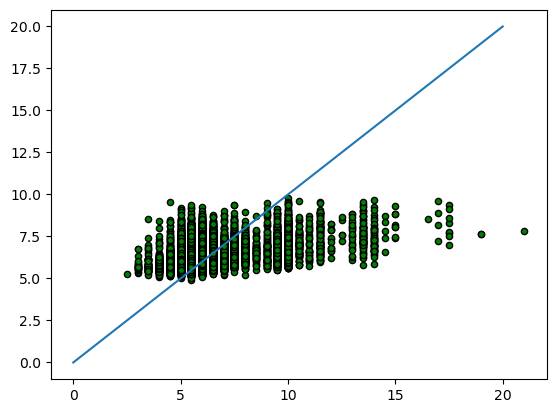

0.1532751047011487
0.17630547391900842


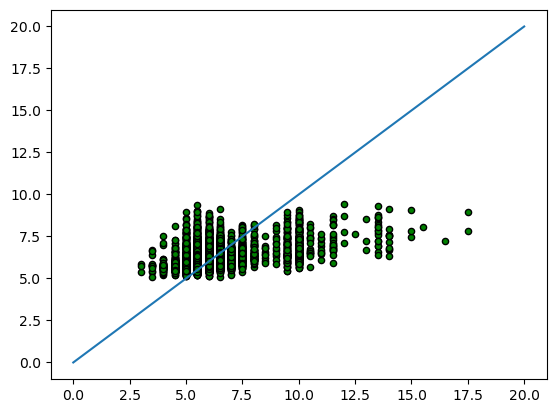

In [17]:
regr = MLPRegressor(max_iter = 400000, solver = 'lbfgs', hidden_layer_sizes = (8, 8), alpha = 500, verbose = True)

regr.fit(X_train, y_train)


y_train_predict = regr.predict(X_train)

plt.plot([0, 20], [0, 20])

plt.scatter(y_train[:, 0], y_train_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_train[:, 1], y_train_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_train[:, 0], y_train_predict[:, 0]))
print(r2_score(y_train[:, 1], y_train_predict[:, 1]))


plt.show()

y_test_predict = regr.predict(X_test)

plt.plot([0, 20], [0, 20])

plt.scatter(y_test[:, 0], y_test_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_test[:, 1], y_test_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_test[:, 0], y_test_predict[:, 0]))
print(r2_score(y_test[:, 1], y_test_predict[:, 1]))


plt.show()

Train neural network for outfield players.

The outputs of the NN are probability distribution of SinhArcsinh type (a skewed distribution, which is a generalization of Gaussian)

In [20]:
load_model_of = True# load scaler and model weights for outfield player predictor
refit_model_of = False

if(load_model_of):
    scaler = pickle.load(open('saves/scaler.pkl', 'rb'))
    
    X_train = scaler.transform(X_train_)
    X_test = scaler.transform(X_test_)


n_epochs = 1000

n_samples = X_train.shape[0]

batch_size = 256

X_len = X_train.shape[1]
y_len = y_train.shape[1]


#tailweight_param = 1.1

tailweight_min = 0.5
tailweight_range = 1.2


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)


inputs = tfk.layers.Input(shape=(X_len,), name="input")
x = tfk.layers.Dropout(0.2)(inputs)
x = tfk.layers.Dense(16, activation="relu") (x)
x = tfk.layers.Dropout(0.2)(x)
x = tfk.layers.Dense(16, activation="relu") (x)


prob_dist_params = 4

def prob_dist(t): 
    return tfp.distributions.SinhArcsinh(loc=t[..., 0], scale=1e-3 + tf.math.softplus(t[..., 1]), skewness = t[..., 2], 
                                        tailweight = tailweight_min + tailweight_range * tf.math.sigmoid(t[..., 3]),
                                        allow_nan_stats = False)

x1 = tfk.layers.Dense(8, activation="sigmoid")(x)
x1 = tfk.layers.Dense(prob_dist_params, activation="linear")(x1)
out_1 = tfp.layers.DistributionLambda(prob_dist)(x1)

x2 = tfk.layers.Dense(8, activation="sigmoid")(x)
x2 = tfk.layers.Dense(prob_dist_params, activation="linear")(x2)
out_2 = tfp.layers.DistributionLambda(prob_dist)(x2)


modelb = tf.keras.Model(inputs, [out_1, out_2])

modelb.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.001), 
              loss=neg_log_likelihood)

if(load_model_of):
    modelb.load_weights('saves/modelb')
    
if( (not load_model_of) or refit_model_of):
    modelb.fit(X_train.astype('float32'), [y_train[:, 0].astype('float32'), y_train[:, 1].astype('float32')], 
              validation_data = (X_test.astype('float32'), [y_test[:, 0].astype('float32'), y_test[:, 1].astype('float32')]),
              batch_size = batch_size, shuffle = True, epochs=n_epochs, verbose=True, callbacks = [callback])

In [21]:
def sample_predict(X, iterations = 100):
    y = np.zeros((2, X.shape[0]))
    
    dist = modelb(X)
    
    for i in range(iterations):
        y[0, :] += dist[0].sample()
        y[1, :] += dist[1].sample()
        
    return y.transpose() / iterations
    

0.13385223635677934
0.1536831746216616


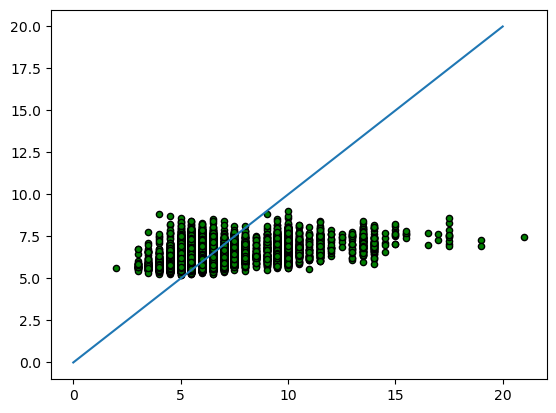

0.127508905428527
0.147998716039207


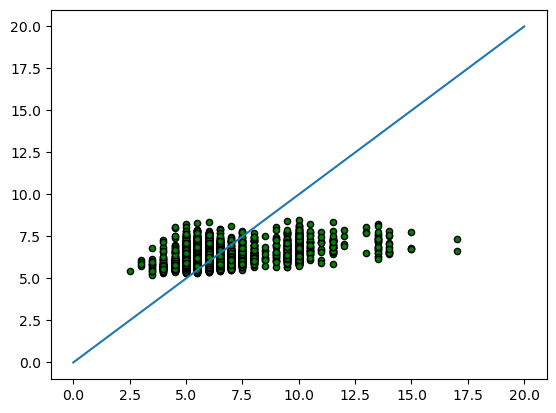

In [38]:
y_train_predict = sample_predict(X_train)

plt.plot([0, 20], [0, 20])

plt.scatter(y_train[:, 0], y_train_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_train[:, 1], y_train_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_train[:, 0], y_train_predict[:, 0]))
print(r2_score(y_train[:, 1], y_train_predict[:, 1]))

plt.show()

y_test_predict = sample_predict(X_test)

plt.plot([0, 20], [0, 20])

plt.scatter(y_test[:, 0], y_test_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_test[:, 1], y_test_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_test[:, 0], y_test_predict[:, 0]))
print(r2_score(y_test[:, 1], y_test_predict[:, 1]))




Train neural network for goalkeepers.

For clean sheet probability prediction, a Bernoulli distribution is used.

In [22]:
load_model_gk = True# load scaler and model weights for goalkeeper player predictor
refit_model_gk = False

if(load_model_gk):
    scaler_gk = pickle.load(open('saves/scaler_gk.pkl', 'rb'))
    
    X_gk_train = scaler_gk.transform(X_gk_train_)
    X_gk_test = scaler_gk.transform(X_gk_test_)
    
    
n_epochs = 2500

n_samples = X_gk_train.shape[0]

batch_size = 128

X_gk_len = X_gk_train.shape[1]
y_gk_len = y_gk_train.shape[1]


#tailweight_param = 1.1

tailweight_min = 0.5
tailweight_range = 1.1


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 50)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)


inputs = tfk.layers.Input(shape=(X_gk_len,), name="input")
x = tfk.layers.Dense(16, activation="relu") (inputs)
x = tfk.layers.Dropout(0.2)(x)
x = tfk.layers.Dense(16, activation="relu") (x)


prob_dist_params = 4

def prob_dist(t): 
    return tfp.distributions.SinhArcsinh(loc=t[..., 0], scale=1e-3 + tf.math.softplus(t[..., 1]), skewness = t[..., 2], 
                                        tailweight = tailweight_min + tailweight_range * tf.math.sigmoid(t[..., 3]),
                                        allow_nan_stats = False)

x1 = tfk.layers.Dense(8, activation="sigmoid")(x)
x1 = tfk.layers.Dense(prob_dist_params, activation="linear")(x1)
out_1 = tfp.layers.DistributionLambda(prob_dist)(x1)

x2 = tfk.layers.Dense(8, activation="sigmoid")(x)

x2 = tfk.layers.Dense(prob_dist_params, activation="linear")(x2)
out_2 = tfp.layers.DistributionLambda(prob_dist)(x2)

x3 = tfk.layers.Dense(8, activation="sigmoid")(x)
x3 = tfk.layers.Dropout(0.5)(x3)
x3 = tfk.layers.Dense(1, activation="sigmoid")(x3)
out_3 = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Bernoulli(probs = t[..., 0]))(x3)

modelb_gk = tf.keras.Model(inputs, [out_1, out_2, out_3])

modelb_gk.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.001), 
              loss=neg_log_likelihood)

if(load_model_gk):
    modelb_gk.load_weights('saves/modelb_gk')

if( (not load_model_gk) or refit_model_gk):    
    modelb_gk.fit(X_gk_train.astype('float32'), [y_gk_train[:, 0].astype('float32'), y_gk_train[:, 1].astype('float32'), y_gk_train[:, 2].astype('int')], 
              validation_data = (X_gk_test.astype('float32'), [y_gk_test[:, 0].astype('float32'), y_gk_test[:, 1].astype('float32'), y_gk_test[:, 2].astype('int')]),
              batch_size = batch_size, shuffle = True, epochs=n_epochs, verbose=True, callbacks = [callback])

In [23]:
def sample_predict_gk(X, iterations = 100):
    y = np.zeros((3, X.shape[0]))
    
    dist = modelb_gk(X)
    
    for i in range(iterations):
        y[0, :] += dist[0].sample()
        y[1, :] += dist[1].sample()
        y[2, :] += dist[2].sample()
        
    return y.transpose() / iterations


0.3243084984831396
0.560534541338418


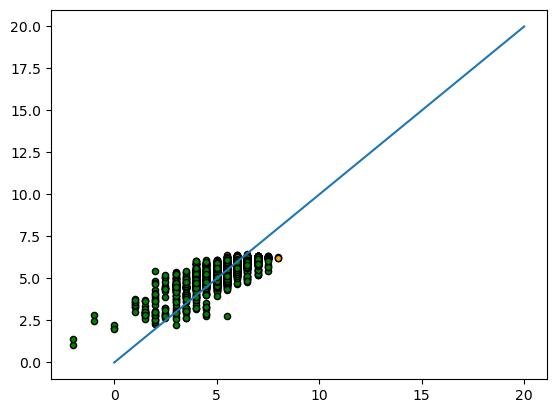

0.262934291751185
0.42164057262465204


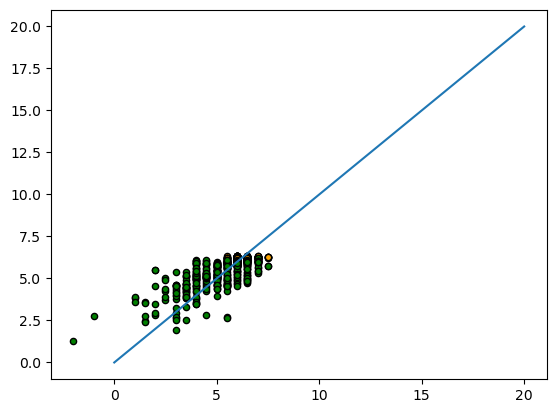

In [23]:
y_gk_train_predict = sample_predict_gk(X_gk_train)

plt.plot([0, 20], [0, 20])

plt.scatter(y_gk_train[:, 0], y_gk_train_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_gk_train[:, 1], y_gk_train_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_gk_train[:, 0], y_gk_train_predict[:, 0]))
print(r2_score(y_gk_train[:, 1], y_gk_train_predict[:, 1]))

plt.show()

y_gk_test_predict = sample_predict_gk(X_gk_test)

plt.plot([0, 20], [0, 20])

plt.scatter(y_gk_test[:, 0], y_gk_test_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_gk_test[:, 1], y_gk_test_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_gk_test[:, 0], y_gk_test_predict[:, 0]))
print(r2_score(y_gk_test[:, 1], y_gk_test_predict[:, 1]))




Use the following codes to save the scalers and the model weights

In [24]:
save_model_of = False
save_model_gk = False

if(save_model_of):
    pickle.dump(scaler, open('saves/scaler.pkl', 'wb'))
    modelb.save_weights('saves/modelb')
    
if(save_model_gk):
    pickle.dump(scaler_gk, open('saves/scaler_gk.pkl', 'wb'))
    modelb_gk.save_weights('saves/modelb_gk')
    

Generalized prediction function for a player (playing for team against opp_team, at home or not)

Estimate prediction mean and sigma (using a custom definitions).

Generate a plot.


In [24]:
def vote_predict_NNb(player, team, opp_team, home = 1, plot = 0, log = 0, oldseason = False):
    if(players['r'][player] == 'P'):
        ptest = player_match_data_ext_gk(player, team, opp_team, oldseason = oldseason)

        x_ptest = np.array(ptest)[:, 3:]
        r = np.array(ptest)[0, 0]

        # add home and role
        xadd = np.zeros((1, 1))
        xadd[0, 0] = home

        x_ptest = np.concatenate((x_ptest, xadd), axis = 1)

        x_scaled = scaler_gk.transform(x_ptest)

        dist = modelb_gk(x_scaled)
        
        clean_shoot_prob = dist[2].probs.numpy()[0]
    else:
        ptest = player_match_data_ext(player, team, opp_team, oldseason = oldseason)

        x_ptest = np.array(ptest)[:, 4:]
        r = np.array(ptest)[0, 0]

        # add home and role
        xadd = np.zeros((1, 4))
        xadd[0, 0] = home
        xadd[0, 1] = r == 'D'
        xadd[0, 2] = r == 'C'
        xadd[0, 3] = r == 'A'

        x_ptest = np.concatenate((x_ptest, xadd), axis = 1)

        x_scaled = scaler.transform(x_ptest)

        dist = modelb(x_scaled)
    
    
    x = np.arange(0, 40, 0.002)

    px1 = dist[0].prob(x);
    px2 = dist[1].prob(x);

    
    #sample1 = dist[0].sample(10000)
    #sample2 = dist[1].sample(10000)
    
    m1 = np.average(x, weights = px1)
    m2 = np.average(x, weights = px2)
    
    #m1 = np.mean(sample1)
    #m2 = np.mean(sample2)
    
    #s1 = np.std(sample1)
    #s2 = np.std(sample2)
      
    # not standard deviation, but expected range extimated by quantile 
    
    if(players['r'][player] == 'P'):
        s1 = ( dist[0].quantile(0.9545) - m1 ) / 2
        s2 = -( dist[1].quantile(1 - 0.9) - m2 ) / 2
    else:
        s1 = ( dist[0].quantile(0.9545) - m1 ) / 2
        s2 = ( dist[1].quantile(0.9) - m2 ) / 2
    

    
    #y_pred_m = np.array([dist[0].loc, dist[1].loc]).flatten()
    y_pred_m = np.array([m1, m2]).flatten()
    #y_pred_s = np.array([dist[0].scale, dist[1].scale]).flatten()
    y_pred_s = np.array([s1, s2]).flatten()
    
    clean_sheet_text = ''
    if(players['r'][player] == 'P'):
        clean_sheet_text = ' (' + "{:.1f}".format(clean_shoot_prob*100) + '% cs)'
            
    if(plot):
        ax = plt.gca()
        
        plt.plot(x, px1, 
                 label = 'MV ' + "{:.2f}".format(y_pred_m[0]) + ' ± ' + "{:.2f}".format(2 * y_pred_s[0]),
                color = 'b')
        plt.plot(x, px2, 
                 label = 'FV ' + "{:.2f}".format(y_pred_m[1]) + ' + ' + "{:.2f}".format(2 * y_pred_s[1]) + clean_sheet_text,
                color = 'g')
        
        plt.fill_between(x, px1, color = 'lightblue')
        plt.fill_between(x, px2, color = 'lightgreen')
        
        plt.legend()
        
        plt.vlines(x = y_pred_m[0], color = 'b', ymin = 0, ymax = 3, linestyle = 'dashed')
        plt.vlines(x = y_pred_m[1], color = 'g', ymin = 0, ymax = 3, linestyle = 'dashed')
        
        plt.title(player + ' (' + team + ' vs ' + opp_team + ')')
        
        plt.xlim([0, 15])
        
        if(players['r'][player] == 'P'):            
            plt.ylim([0, 2.5])
        else:
            plt.ylim([0, 1.5])
        
        plt.show()
        
    if(log):
        print(player + ': ' + 
         'MV ' + "{:.2f}".format(y_pred_m[0]) + ' ± ' + "{:.2f}".format(2 * y_pred_s[0]) +
         '; FV ' + "{:.2f}".format(y_pred_m[1]) + ' + ' + "{:.2f}".format(2 * y_pred_s[1]) + clean_sheet_text);
    return [y_pred_m, y_pred_s, dist]


Load Serie A calendar. 

In [44]:
cal = np.array(pd.read_excel('fantacalcio/seriea_calendar.xlsx', header = None))

cal_df = pd.DataFrame(columns = ['matchday', 'team1', 'team2'])

matchday = 0

for i in range(cal.shape[0]):
    if(cal[i, 0][0].isnumeric()):
        matchday = matchday + 1
        continue
    
    teams = cal[i, 0].split('-')
    
    frame = pd.DataFrame([[matchday, teams[0], teams[1]]], columns = cal_df.columns)

    cal_df = pd.concat([cal_df, frame], ignore_index = True)
    

In [45]:
print(cal_df.to_string())

    matchday        team1        team2
0          1   Fiorentina    Cremonese
1          1       Verona       Napoli
2          1     Juventus     Sassuolo
3          1        Lazio      Bologna
4          1        Lecce        Inter
5          1        Milan      Udinese
6          1        Monza       Torino
7          1  Salernitana         Roma
8          1    Sampdoria     Atalanta
9          1       Spezia       Empoli
10         2     Atalanta        Milan
11         2      Bologna       Verona
12         2       Empoli   Fiorentina
13         2        Inter       Spezia
14         2       Napoli        Monza
15         2         Roma    Cremonese
16         2    Sampdoria     Juventus
17         2     Sassuolo        Lecce
18         2       Torino        Lazio
19         2      Udinese  Salernitana
20         3    Cremonese       Torino
21         3   Fiorentina       Napoli
22         3       Verona     Atalanta
23         3     Juventus         Roma
24         3        Lecce

Function for generating a prediction for a player, taking match data from a given matchday, according to Serie A calendar.

In [26]:
def PlayerMatch(player, match = 0):
    team = players.loc[player]['team']
    
    if(match == 0):
        oppteam = 'Avg'
        home = 1
    else:
        for i in range (cal_df.shape[0]):
            if(cal_df['matchday'][i] == match):
                if(cal_df['team1'][i] == team):
                    home = 1
                    oppteam = cal_df['team2'][i]
                elif(cal_df['team2'][i] == team):
                    home = 0
                    oppteam = cal_df['team1'][i]
                
    return [player, team, oppteam, home]

def predict_player(player, match = 0, plot = 0, log = 0, oldseason = False):
    [player, team, oppteam, home] = PlayerMatch(player, match)
    return vote_predict_NNb(player, team, oppteam, home = home, plot = plot, log = log, oldseason = oldseason)

Load current matchday playing probabilities for Serie A players.

In [27]:
probables = pd.read_excel('mid_outputs/match_probable_players.xlsx', index_col = 0)   

probables

,starter,percentage
player,,
Maignan,1.00,90
Calabria,0.60,60
Kjaer,0.55,55
Tomori,1.00,70
Hernandez T.,1.00,90
...,...,...
Bonifazi,0.40,30
Pyyhtia,0.00,30
Aebischer,0.45,60


Generate prediction data for each Serie A player for the current matchday.

Output to excel file, using a template made for data elaboration.

In [46]:
matchday_out = 34

output = pd.DataFrame(columns = ['player', 'role', 'team', 'oppteam', 'home', 'starter', 'vote%', 'MV', 'MV std', 'FV', 'FV std', 'MV loc', 'MV scale', 'MV skewness', 'MV tailweight', 'FV loc', 'FV scale', 'FV skewness', 'FV tailweight', 'Clean Sheet %'])

for i in range(players.shape[0]):
    try:
        [player, team, oppteam, home] = PlayerMatch(players.index[i], matchday_out)
        
        [mean, std, dist] = vote_predict_NNb(player, team, oppteam, home = home, log = 1)
        
        role = players['r'][player] 
        
        starter = 0
        voteperc = 0
        
        cs = 0
        if(role == 'P'):
            cs = dist[2].probs.numpy()[0] * 100
        
        if(player in probables.index):
            starter = probables['starter'][player]
            voteperc = probables['percentage'][player]
        
        row = [player, role, team, oppteam, home, 
               starter, voteperc, 
               mean[0], std[0], 
               mean[1], std[1], 
               dist[0].loc.numpy()[0], dist[0].scale.numpy()[0], 
               dist[0].skewness.numpy()[0], dist[0].tailweight.numpy()[0], 
               dist[1].loc.numpy()[0], dist[1].scale.numpy()[0], 
               dist[1].skewness.numpy()[0], dist[1].tailweight.numpy()[0],
               cs]
        
        row_df = pd.DataFrame(data = [row], columns = output.columns)
        
        output = pd.concat([output, row_df])
        
    except:
        print(players.index[i] + ' no data')

output = output.set_index('player')

output = output.sort_values(['team', 'role', 'FV'], ascending = [True, False, False])
#output.to_excel('outputs/pred_matchday_' + str(matchday_out) + '.xlsx')

output

Meret: MV 6.25 ± 0.82; FV 5.94 + 0.90 (73.6% cs)
Provedel: MV 6.25 ± 0.82; FV 6.05 + 1.08 (71.1% cs)
Vicario: MV 6.25 ± 0.82; FV 5.79 + 0.85 (45.4% cs)
Szczesny: MV 6.25 ± 0.82; FV 4.92 + 1.54 (3.6% cs)
Falcone: MV 6.25 ± 0.82; FV 5.76 + 0.80 (36.1% cs)
Silvestri: MV 6.25 ± 0.82; FV 5.73 + 1.07 (51.7% cs)
Rui Patricio: MV 6.25 ± 0.82; FV 5.41 + 1.33 (40.3% cs)
Onana: MV 6.25 ± 0.82; FV 5.41 + 1.26 (25.4% cs)
Sepe: MV 6.25 ± 0.82; FV 5.34 + 0.83 (10.1% cs)
Milinkovic-Savic V.: MV 6.25 ± 0.82; FV 5.88 + 1.06 (43.5% cs)
Musso: MV 6.25 ± 0.82; FV 5.04 + 0.69 (8.0% cs)
Maignan: MV 6.25 ± 0.82; FV 5.85 + 0.93 (43.2% cs)
Carnesecchi: MV 6.25 ± 0.82; FV 5.11 + 1.47 (36.7% cs)
Di Gregorio: MV 6.25 ± 0.82; FV 5.33 + 0.99 (10.5% cs)
Audero: MV 6.25 ± 0.82; FV 4.88 + 1.26 (14.6% cs)
Montipo': MV 6.07 ± 0.70; FV 5.07 + 1.32 (29.0% cs)
Skorupski: MV 6.06 ± 0.71; FV 5.09 + 1.46 (20.9% cs)
Consigli: MV 6.25 ± 0.82; FV 5.02 + 1.23 (8.9% cs)
Dragowski: MV 6.25 ± 0.82; FV 5.76 + 1.10 (40.5% cs)
Terraccia

Romagnoli S.: MV 6.12 ± 0.99; FV 6.47 + 1.57
Ghiglione: MV 5.99 ± 0.83; FV 6.20 + 1.28
Rugani: MV 5.98 ± 0.62; FV 5.95 + 0.51
De Sciglio: MV 5.84 ± 0.64; FV 5.84 + 0.53
Djimsiti: MV 5.96 ± 0.73; FV 5.94 + 0.66
Caldara: MV 5.83 ± 0.85; FV 5.81 + 0.87
Karsdorp: MV 5.89 ± 0.80; FV 5.90 + 0.85
Marchizza: MV 5.81 ± 0.81; FV 5.77 + 0.76
Kjaer: MV 5.93 ± 0.74; FV 5.86 + 0.66
Okoli: MV 5.76 ± 0.88; FV 5.69 + 0.81
Amione: MV 5.72 ± 0.98; FV 5.66 + 1.15
Ruggeri: MV 5.91 ± 0.66; FV 5.89 + 0.56
Zanoli: MV 5.93 ± 0.90; FV 6.07 + 1.28
Wisniewski: MV 5.84 ± 0.64; FV 5.81 + 0.55
Radovanovic: MV 5.75 ± 0.70; FV 5.71 + 0.62
Dermaku: MV 6.02 ± 0.77; FV 6.08 + 0.83
D'ambrosio: MV 6.02 ± 0.79; FV 6.08 + 0.89
De Silvestri: MV 5.88 ± 1.01; FV 6.00 + 1.34
Chiriches: MV 5.94 ± 0.76; FV 5.91 + 0.70
Murru: MV 5.66 ± 0.75; FV 5.59 + 0.78
Bonifazi: MV 5.69 ± 0.85; FV 5.63 + 0.82
Donati: MV 5.72 ± 1.15; FV 5.80 + 1.55
Walukiewicz: MV 6.06 ± 0.65; FV 5.97 + 0.57
Ranieri L.: MV 5.70 ± 0.81; FV 5.69 + 0.94
Gabbia: MV 

Marcos Antonio: MV 6.04 ± 0.89; FV 6.32 + 1.43
Fazzini: MV 5.86 ± 0.63; FV 5.81 + 0.57
Sulemana I.: MV 5.88 ± 0.60; FV 5.90 + 0.51
Tahirovic: MV 5.84 ± 0.77; FV 5.78 + 0.85
Abildgaard: MV 5.77 ± 0.63; FV 5.82 + 0.58
Barberis: MV 5.75 ± 0.81; FV 5.72 + 0.87
Kastanos: MV 5.98 ± 0.81; FV 6.10 + 0.98
Vignato: MV 6.01 ± 0.73; FV 6.10 + 0.84
Valoti: MV 5.74 ± 0.65; FV 5.70 + 0.61
Winks: MV 5.83 ± 0.86; FV 5.81 + 0.98
Askildsen: MV 5.85 ± 0.61; FV 5.84 + 0.50
Bove: MV 5.99 ± 0.82; FV 6.20 + 1.20
Bohinen: MV 5.89 ± 0.58; FV 5.86 + 0.45
D'andrea: MV 6.04 ± 0.77; FV 6.18 + 0.95
Iling-Junior: MV 6.03 ± 0.74; FV 6.18 + 1.01
Cipot: MV 6.08 ± 0.63; FV 6.26 + 0.92
Bakayoko: MV 5.80 ± 0.74; FV 5.79 + 0.65
Gaetano: MV 5.93 ± 0.75; FV 5.98 + 0.82
Zurkowski: MV 6.05 ± 0.97; FV 6.47 + 1.76
Castrovilli: MV 5.90 ± 0.85; FV 6.07 + 1.25
Demme: MV 6.02 ± 0.73; FV 6.22 + 1.03
Darboe: MV 5.91 ± 0.94; FV 5.97 + 1.11
Urbanski: MV 5.93 ± 0.86; FV 5.98 + 0.98
Bertini: MV 5.88 ± 0.96; FV 5.98 + 1.31
Yepes: MV 5.70 ± 

,role,team,oppteam,home,starter,vote%,MV,MV std,FV,FV std,MV loc,MV scale,MV skewness,MV tailweight,FV loc,FV scale,FV skewness,FV tailweight,Clean Sheet %
player,,,,,,,,,,,,,,,,,,,
Musso,P,Atalanta,Juventus,1,0.55,55,6.254405,0.411209,5.035751,0.342500,5.984879,0.167509,0.880999,1.599276,5.014495,0.525508,0.029776,0.913046,8.038829
Rossi F.,P,Atalanta,Juventus,1,0.00,1,6.231914,0.405208,4.289062,0.420042,5.969362,0.175638,0.840497,1.599256,4.279346,0.646178,0.011079,0.935691,1.963351
Sportiello,P,Atalanta,Juventus,1,0.45,5,6.254370,0.411102,4.214338,0.326933,5.984973,0.167680,0.880164,1.599276,4.193475,0.500380,0.030683,0.902728,1.160084
Zappacosta,D,Atalanta,Juventus,1,1.00,80,6.056584,0.466738,6.304006,0.701212,5.997294,0.535322,0.081726,1.021092,5.791334,0.955869,0.377559,1.599911,0.000000
Scalvini,D,Atalanta,Juventus,1,1.00,90,5.989745,0.493339,6.162027,0.656128,6.000084,0.586076,-0.013022,0.993997,5.786531,1.002288,0.271447,1.599920,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gaich,A,Verona,Lecce,0,0.00,60,5.825243,0.460409,6.066322,0.662139,5.738146,0.518114,0.123950,1.051589,5.519838,0.823035,0.455078,1.599903,0.000000
Djuric,A,Verona,Lecce,0,1.00,80,5.880368,0.341485,5.978157,0.351269,5.841517,0.396984,0.072532,1.175740,5.826691,0.577211,0.193079,1.599953,0.000000
Kallon,A,Verona,Lecce,0,0.00,40,5.824849,0.398117,5.971637,0.533920,5.761679,0.453794,0.102902,1.116911,5.576400,0.722054,0.384482,1.599924,0.000000


In [47]:
import shutil

template_file = 'outputs/pred_matchday_base.xlsx'
dest_file = 'outputs/pred_matchday_' + str(matchday_out) + '.xlsx'

shutil.copyfile(template_file, dest_file)

with pd.ExcelWriter(dest_file, mode = 'a', engine="openpyxl", if_sheet_exists = 'replace') as writer:  
    output.to_excel(writer, sheet_name='data')

Predict average Serie A performance for each player

In [30]:
gk_starters = ['Maignan', 'Ochoa', 'Silvestri', 'Consigli', 'Provedel', 'Di Gregorio', 'Meret', 'Milinkovic-Savic V.',
              'Terracciano', 'Onana', 'Szczesny', 'Skorupski', 'Vicario', 'Musso', 'Carnesecchi', 'Rui Patricio',
              'Montipo\'', 'Falcone', 'Dragowski', 'Audero']

In [31]:
output = pd.DataFrame(columns = ['player', 'role', 'team', 'oppteam', 'home', 'starter', 'vote%', 'MV', 'MV std', 'FV', 'FV std', 'MV loc', 'MV scale', 'MV skewness', 'MV tailweight', 'FV loc', 'FV scale', 'FV skewness', 'FV tailweight', 'Clean Sheet %'])

tot_matches = 2 # home and not home

current_season_games = max(players_orig['games'])

for i in range(players.shape[0]):
    try:
        home = 0

        for k in range(tot_matches):
            #matchday_out = k + 1
            #[player, team, oppteam, home] = PlayerMatch(players.index[i], matchday_out)

            player = players.index[i]
            team = players['team'][i]
            oppteam = 'Avg'
            home = not home

            [mean, std, dist] = vote_predict_NNb(player, team, oppteam, home = home)

            role = players['r'][player] 

            starter = 0
            voteperc = 0

            games = max( players_orig['games'][i], players_orig['gk_games'][i] )
            mins = max( players_orig['minutes'][i], players_orig['gk_minutes'][i] )

            cs = 0
            if(role == 'P'):
                cs = dist[2].probs.numpy()[0] * 100

                starter = int( player in gk_starters )
                if(starter):
                    voteperc = 100
                else:
                    voteperc = 0
            else:
                starter = int ( 1 * (games >= current_season_games * 2/3 and mins / games >= 45 ) )
                voteperc = int( min( 1, games / current_season_games ) * 100)     

            if(k == 0):
                row = [player, role, team, 'Avg', 1, starter, voteperc]

            numrow_ = [mean[0], std[0], 
                   mean[1], std[1], 
                   dist[0].loc.numpy()[0], dist[0].scale.numpy()[0], 
                   dist[0].skewness.numpy()[0], dist[0].tailweight.numpy()[0], 
                   dist[1].loc.numpy()[0], dist[1].scale.numpy()[0], 
                   dist[1].skewness.numpy()[0], dist[1].tailweight.numpy()[0],
                   cs]            

            if(k == 0):
                numrow = numrow_
            else:
                for j in range(len(numrow)):
                    numrow[j] += numrow_[j]

        for j in range(len(numrow)):
            numrow[j] /= tot_matches

        print(players.index[i] + ' (' + "{:.2f}".format(numrow[0]) + ', ' + "{:.2f}".format(numrow[1]) + 
              '); (' + "{:.2f}".format(numrow[2]) + ', ' + "{:.2f}".format(numrow[3]) + ')' )

        row += numrow # list concat

        row_df = pd.DataFrame(data = [row], columns = output.columns)

        output = pd.concat([output, row_df])
    except:
        print(players.index[i] + ' no data')
    
        

output = output.set_index('player')

output = output.sort_values(['team', 'role', 'FV'], ascending = [True, False, False])
#output.to_excel('outputs/pred_matchday_' + str(matchday_out) + '.xlsx')

output

Meret (6.25, 0.41); (5.72, 0.53)
Provedel (6.19, 0.38); (5.54, 0.56)
Vicario (6.25, 0.41); (5.39, 0.57)
Szczesny (6.25, 0.41); (6.02, 0.47)
Falcone (6.17, 0.38); (4.61, 0.47)
Silvestri (6.25, 0.41); (5.65, 0.60)
Rui Patricio (6.19, 0.40); (5.37, 0.64)
Onana (6.17, 0.38); (5.20, 0.58)
Sepe (6.21, 0.40); (4.99, 0.54)
Milinkovic-Savic V. (5.98, 0.36); (4.91, 0.74)
Musso (6.25, 0.41); (5.55, 0.52)
Maignan (6.25, 0.41); (4.89, 0.50)
Carnesecchi (6.25, 0.41); (5.31, 0.59)
Di Gregorio (6.18, 0.39); (5.11, 0.72)
Audero (6.25, 0.41); (4.96, 0.53)
Montipo' (6.19, 0.38); (4.69, 0.39)
Skorupski (6.25, 0.41); (5.51, 0.55)
Consigli (6.24, 0.40); (5.42, 0.63)
Dragowski (6.25, 0.41); (5.46, 0.63)
Terracciano (6.06, 0.39); (4.65, 0.75)
Tatarusanu (6.25, 0.41); (4.93, 0.79)
Handanovic (6.25, 0.41); (5.99, 0.51)
Sportiello (6.22, 0.39); (4.55, 0.40)
Perin (6.25, 0.41); (5.97, 0.45)
Zoet (6.25, 0.41); (6.03, 0.51)
Ochoa (6.25, 0.41); (5.71, 0.56)
Pegolo (6.25, 0.41); (4.75, 0.58)
Gollini (6.25, 0.41); (5.

Sambia (5.87, 0.37); (5.89, 0.35)
Moutinho J. (5.82, 0.39); (5.78, 0.40)
Conti (5.88, 0.42); (5.96, 0.56)
Marrone (5.63, 0.43); (5.56, 0.45)
Tonelli (5.80, 0.43); (5.75, 0.41)
Murillo (5.69, 0.41); (5.57, 0.40)
Radu (5.80, 0.47); (5.75, 0.42)
Paletta (5.91, 0.45); (6.00, 0.56)
Florenzi (6.08, 0.37); (6.22, 0.46)
Sala (5.85, 0.35); (5.86, 0.37)
Fares (5.84, 0.37); (5.84, 0.40)
Romagna (5.90, 0.45); (5.93, 0.52)
Cassandro (5.93, 0.44); (5.98, 0.50)
Muldur (5.78, 0.39); (5.73, 0.40)
Amey (6.04, 0.42); (6.15, 0.51)
Zanotti (5.93, 0.44); (6.00, 0.52)
Ebosele (5.93, 0.32); (5.93, 0.28)
Buta (5.93, 0.44); (6.00, 0.51)
Abankwah (5.91, 0.43); (5.95, 0.49)
Guessand A. (5.93, 0.44); (6.00, 0.51)
Cabal (5.95, 0.33); (5.91, 0.28)
Sosa (5.61, 0.44); (5.54, 0.46)
Guarino (5.91, 0.45); (5.96, 0.52)
Carboni F. (6.02, 0.42); (6.11, 0.49)
Zaccagni (6.39, 0.58); (7.21, 1.33)
Kvaratskhelia (6.49, 0.66); (7.39, 1.52)
Milinkovic-Savic (6.15, 0.57); (6.84, 1.23)
Barella (6.19, 0.52); (6.76, 1.03)
Zielinski (6

Caprari (5.95, 0.47); (6.27, 0.79)
Di Maria (6.21, 0.61); (6.96, 1.36)
Piatek (5.83, 0.48); (6.21, 0.81)
Rebic (6.00, 0.57); (6.52, 1.07)
Bonazzoli (5.97, 0.48); (6.30, 0.79)
Zapata D. (5.93, 0.48); (6.24, 0.77)
Kouame' (6.02, 0.58); (6.60, 1.12)
Gonzalez N. (6.13, 0.57); (6.80, 1.19)
Brekalo (6.05, 0.54); (6.57, 1.03)
Mota (5.98, 0.56); (6.50, 1.06)
Kean (6.05, 0.61); (6.71, 1.26)
Okereke (5.96, 0.54); (6.44, 0.99)
Ceesay (5.96, 0.51); (6.42, 0.93)
Colombo (5.93, 0.54); (6.44, 1.01)
Dessers (5.99, 0.56); (6.60, 1.13)
Muriel (6.02, 0.53); (6.35, 0.90)
Pinamonti (5.85, 0.50); (6.19, 0.82)
Di Francesco F. (5.96, 0.49); (6.24, 0.78)
Jovic (5.96, 0.56); (6.40, 0.98)
Origi (5.83, 0.47); (6.11, 0.74)
Caputo (5.94, 0.53); (6.40, 0.96)
Boga (6.21, 0.56); (6.86, 1.14)
Cambiaghi (6.16, 0.52); (6.81, 1.13)
Alvarez A. (5.98, 0.52); (6.34, 0.88)
Banda (5.93, 0.39); (6.05, 0.49)
Ciofani D. (6.02, 0.53); (6.55, 1.04)
Petagna (5.93, 0.51); (6.30, 0.86)
Barrow (6.01, 0.56); (6.46, 1.01)
Djuric (5.94, 0

,role,team,oppteam,home,starter,vote%,MV,MV std,FV,FV std,MV loc,MV scale,MV skewness,MV tailweight,FV loc,FV scale,FV skewness,FV tailweight,Clean Sheet %
player,,,,,,,,,,,,,,,,,,,
Musso,P,Atalanta,Avg,1,1,100,6.246662,0.405504,5.551811,0.520479,5.984098,0.176351,0.838341,1.599265,5.810978,0.729997,-0.262806,0.860719,29.652037
Sportiello,P,Atalanta,Avg,1,0,0,6.215503,0.386785,4.551934,0.398519,5.983678,0.214951,0.682581,1.599226,4.483588,0.606908,0.068208,0.879032,5.408993
Rossi F.,P,Atalanta,Avg,1,0,0,5.910575,0.379112,4.049485,0.564528,5.747025,0.329788,0.357371,1.598827,4.163519,0.842991,-0.101138,0.911087,2.865818
Zappacosta,D,Atalanta,Avg,1,0,48,6.092779,0.476883,6.421109,0.777429,6.043412,0.550127,0.066196,1.004575,5.813773,1.011895,0.416726,1.599906,0.000000
Scalvini,D,Atalanta,Avg,1,1,81,6.036415,0.509005,6.294344,0.742164,6.010108,0.594076,0.032801,0.982219,5.784675,1.048351,0.344749,1.599907,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gaich,A,Verona,Avg,1,0,39,5.857898,0.462508,6.131500,0.717901,5.771540,0.520882,0.122180,1.046589,5.525054,0.872228,0.472862,1.599893,0.000000
Djuric,A,Verona,Avg,1,0,69,5.936011,0.356034,6.088906,0.446404,5.884834,0.408801,0.092681,1.156591,5.813459,0.662987,0.298895,1.599941,0.000000
Kallon,A,Verona,Avg,1,0,66,5.871454,0.403444,6.038425,0.566514,5.802306,0.457565,0.111612,1.108458,5.607873,0.752284,0.399625,1.599921,0.000000


In [32]:
import shutil

output = output.sort_values(['role', 'FV'], ascending = [False, False])

template_file = 'outputs/pred_matchday_base.xlsx'
dest_file = 'outputs/pred_avg_seriea.xlsx'

shutil.copyfile(template_file, dest_file)

with pd.ExcelWriter(dest_file, mode = 'a', engine="openpyxl", if_sheet_exists = 'replace') as writer:  
    output.to_excel(writer, sheet_name='data')

Various predictions.

In [33]:
predict_player('Meret', log = 1, plot = 0)
predict_player('Szczesny', log = 1, plot = 0)
predict_player('Provedel', log = 1, plot = 0)
predict_player('Maignan', log = 1, plot = 0)
predict_player('Rui Patricio', log = 1, plot = 0)
predict_player('Onana', log = 1, plot = 0)
predict_player('Milinkovic-Savic V.', log = 1, plot = 0)
predict_player('Musso', log = 1, plot = 0)
predict_player('Vicario', log = 1, plot = 0)
predict_player('Silvestri', log = 1, plot = 0)
predict_player('Terracciano', log = 1, plot = 0)
predict_player('Skorupski', log = 1, plot = 0)
predict_player('Falcone', log = 1, plot = 0)
predict_player('Di Gregorio', log = 1, plot = 0)
predict_player('Consigli', log = 1, plot = 0)
predict_player('Carnesecchi', log = 1, plot = 0)
predict_player('Montipo\'', log = 1, plot = 0)
predict_player('Audero', log = 1, plot = 0)
predict_player('Dragowski', log = 1, plot = 0)
predict_player('Ochoa', log = 1, plot = 0)
predict_player('Tatarusanu', log = 1, plot = 0)
predict_player('Handanovic', log = 1, plot = 0)
predict_player('Sportiello', log = 1, plot = 0)
predict_player('Sepe', log = 1, plot = 0)

Meret: MV 6.25 ± 0.82; FV 5.94 + 0.91 (72.7% cs)
Szczesny: MV 6.25 ± 0.82; FV 5.99 + 0.94 (72.5% cs)
Provedel: MV 6.12 ± 0.71; FV 5.15 + 1.31 (49.0% cs)
Maignan: MV 6.25 ± 0.82; FV 5.23 + 0.95 (18.0% cs)
Rui Patricio: MV 6.25 ± 0.82; FV 5.98 + 0.92 (69.0% cs)
Onana: MV 6.25 ± 0.82; FV 5.94 + 0.96 (67.5% cs)
Milinkovic-Savic V.: MV 6.07 ± 0.70; FV 5.14 + 1.36 (40.4% cs)
Musso: MV 6.25 ± 0.81; FV 5.66 + 1.06 (33.3% cs)
Vicario: MV 6.25 ± 0.82; FV 5.44 + 1.31 (41.5% cs)
Silvestri: MV 6.25 ± 0.82; FV 5.67 + 1.21 (45.3% cs)
Terracciano: MV 6.12 ± 0.73; FV 5.00 + 1.47 (21.3% cs)
Skorupski: MV 6.25 ± 0.82; FV 5.39 + 1.23 (30.1% cs)
Falcone: MV 6.25 ± 0.82; FV 4.75 + 0.86 (4.2% cs)
Di Gregorio: MV 6.25 ± 0.82; FV 5.22 + 1.38 (19.6% cs)
Consigli: MV 6.25 ± 0.82; FV 5.48 + 1.35 (41.0% cs)
Carnesecchi: MV 6.25 ± 0.82; FV 5.58 + 1.23 (40.8% cs)
Montipo': MV 6.25 ± 0.82; FV 4.99 + 0.64 (1.3% cs)
Audero: MV 6.25 ± 0.82; FV 4.76 + 1.14 (3.5% cs)
Dragowski: MV 6.25 ± 0.82; FV 5.30 + 1.33 (18.8% cs)
Oc

[array([6.17110676, 5.03714256]),
 array([0.3830576 , 0.54427254], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=int32>]]

In [36]:
predict_player('Muriel', plot = 0, log = 1)
predict_player('Tonali', plot = 0, log = 1)
predict_player('Lobotka', plot = 0, log = 1)
predict_player('Politano', plot = 0, log = 1)
predict_player('Zapata D.', plot = 0, log = 1)
predict_player('Frattesi', plot = 0, log = 1)
predict_player('Gonzalez N.', plot = 0, log = 1)
predict_player('Abraham', plot = 0, log = 1)
predict_player('Pobega', plot = 0, log = 1)
predict_player('Mario Rui', plot = 0, log = 1)
predict_player('Cuadrado', plot = 0, log = 1)
predict_player('Skriniar', plot = 0, log = 1)
predict_player('Lukaku', plot = 0, log = 1)

Muriel: MV 6.20 ± 1.32; FV 7.29 + 3.53
Tonali: MV 6.23 ± 0.95; FV 6.69 + 1.86
Lobotka: MV 6.17 ± 0.72; FV 6.42 + 1.16
Politano: MV 6.19 ± 0.77; FV 6.62 + 1.48
Zapata D.: MV 6.09 ± 1.19; FV 7.18 + 3.36
Frattesi: MV 6.23 ± 1.19; FV 7.37 + 3.58
Gonzalez N.: MV 6.05 ± 1.07; FV 6.65 + 2.25
Abraham: MV 6.20 ± 1.30; FV 7.66 + 4.26
Pobega: MV 6.02 ± 0.68; FV 6.13 + 0.92
Mario Rui: MV 6.10 ± 0.77; FV 6.25 + 0.98
Cuadrado: MV 5.82 ± 0.95; FV 5.80 + 0.92
Skriniar: MV 5.75 ± 0.68; FV 5.70 + 0.58
Lukaku: MV 6.41 ± 1.42; FV 8.29 + 5.46


[array([6.41176047, 8.29456946]),
 array([0.70926785, 2.7289915 ], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>]]

In [37]:
predict_player('Skriniar', log = 1, oldseason= True)
predict_player('Cuadrado', log = 1, oldseason= True)
predict_player('Bastoni', log = 1, oldseason= True)
predict_player('Barak', log = 1, oldseason= True)
predict_player('Politano', log = 1, oldseason= True)
predict_player('Smalling', log = 1, oldseason= True)
predict_player('Gosens', log = 1, oldseason= True)

predict_player('Skriniar', log = 1, oldseason= False)
predict_player('Cuadrado', log = 1, oldseason= False)
predict_player('Bastoni', log = 1, oldseason= False)
predict_player('Barak', log = 1, oldseason= False)
predict_player('Politano', log = 1, oldseason= False)
predict_player('Smalling', log = 1, oldseason= False)
predict_player('Gosens', log = 1, oldseason= False)

Skriniar: MV 6.14 ± 0.82; FV 6.38 + 1.13
Cuadrado: MV 6.29 ± 0.96; FV 6.83 + 1.94
Bastoni: MV 6.13 ± 0.73; FV 6.32 + 0.98
Barak: MV 6.31 ± 1.41; FV 7.50 + 3.97
Politano: MV 6.18 ± 0.82; FV 6.57 + 1.55
Smalling: MV 6.17 ± 0.86; FV 6.56 + 1.43
Gosens: MV 6.05 ± 0.54; FV 6.11 + 0.66


[array([6.04807256, 6.10812885]),
 array([0.27137518, 0.32888246], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>]]

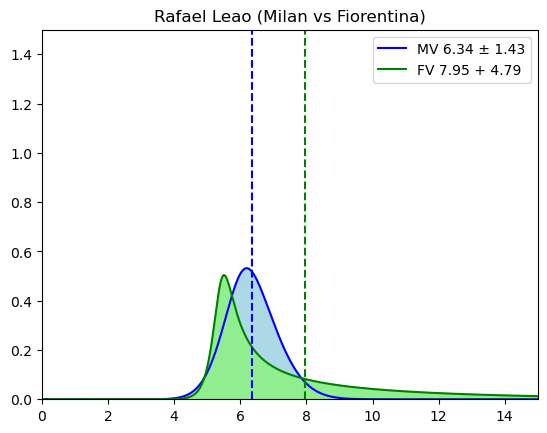

Rafael Leao: MV 6.34 ± 1.43; FV 7.95 + 4.79


[array([6.3442238 , 7.94607029]),
 array([0.71331024, 2.395806  ], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>]]

In [34]:
predict_player('Rafael Leao', plot = 1, log = 1)

Tensorflow seems to have a custom definition for SinhArcsinh distribution. 

Here the code to generate the probability density function is reproduced.

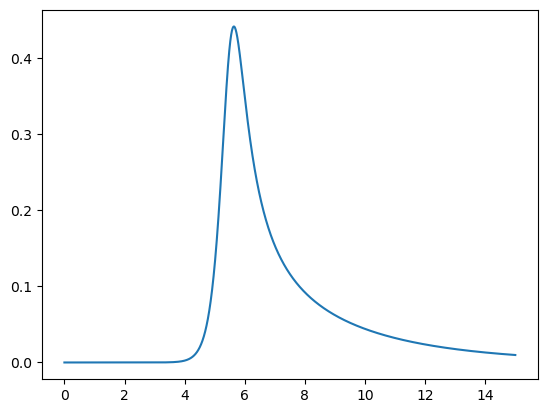

In [110]:
# custom franction to calculate the probability density function

def sinh_archsinh_pdf(x, mu, sigma, eps, delta):

    mul = np.sinh( np.arcsinh(2) * delta)
    
    mul = 2 / mul
    
    sigma_corr = sigma * mul
    
    z = (x - mu) / sigma_corr
    
    
    
    S = np.sinh( -eps + (1/delta) * np.arcsinh(z))
    
    f = np.exp(-0.5 * S * S)

    f /= np.sqrt(2 * np.pi)
    
    f *= 1 / ( sigma_corr * delta )
    
    f *= np.sqrt(1 + S * S)
    
    f /= np.sqrt(1 + z * z)
    
    return f
    

x = np.arange(start = 0, stop = 15, step = 0.001)


plt.plot(x, sinh_archsinh_pdf(x, 5.54, 1.4, 0.8, 1.68))


